In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import wntr
import scipy as sc
import networkx as nx
import networkx.drawing.nx_pylab as nxp
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample
import random
import time
import pickle
import pipedream_utility as pdu
from pipedream_utility import *
import pipedream_simulation as pd_sim
from pipedream_simulation import *
import pipedream_simulation_sensor_results as pd_sim_sensor
from pipedream_simulation_sensor_results import *
from pipedream_kalman_filter import apply_EKF
import viswaternet as vis

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
images_dir = 'img/'
 
# INPUTS ######################################################################
sensors_list = []  
max_sensors = 2
percentile = 90
cutoff_timestep = 5
metric = 'mean'
percent = True
Rcov_case = 1
banded = False
source_node = True

t_run = 24
dt = 1800
Rcov_case=1

In [2]:
inp = 'PA1'
inp_path = f'./networks/{inp}.inp'

In [3]:
wn = wntr.network.WaterNetworkModel(inp_path)

In [4]:
sensor_list = ['433', '221', '190', '163', '293']

In [5]:
#### MAKE SURE THIS DOESN'T GET DUPLICATED
tanks_list = ['338', '186']
sources_list = []
known_measurements_list = tanks_list + sources_list
msmts = known_measurements_list + sensor_list

In [6]:
m = len(msmts)
n = wn.num_nodes + wn.num_tanks # we are adding the "fake" nodes connected to tank orifices

In [7]:
sensor_std_dev = 0.1

In [8]:
Qcov = (10) * np.eye(n)

In [9]:
kf = {}

for i in range(len(msmts)):
    print('Sensors: ', i)
    subset = msmts[:i+1]
    Rcov = (0.5**2) * np.eye(i + 1)
    H_df_kf, H_df_real, H_df_model, H_df_sensor, model = apply_EKF(inp_path, subset, t_run=t_run, dt=dt,
                                                                   banded=banded, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, 
                                                                   num_iter=40)
    kf[i+1] = H_df_kf
kf[0] = H_df_model

Sensors:  0
Sensors:  1
Sensors:  2
Sensors:  3
Sensors:  4
Sensors:  5
Sensors:  6


In [10]:
%matplotlib inline

In [11]:
mads = {}

for i in kf:
    mads[i] = (kf[i] - H_df_real).abs()

In [12]:
mads[7].mean().mean()

0.2868047772833874

In [13]:
mads[0].mean().mean()

1.9465749358956255

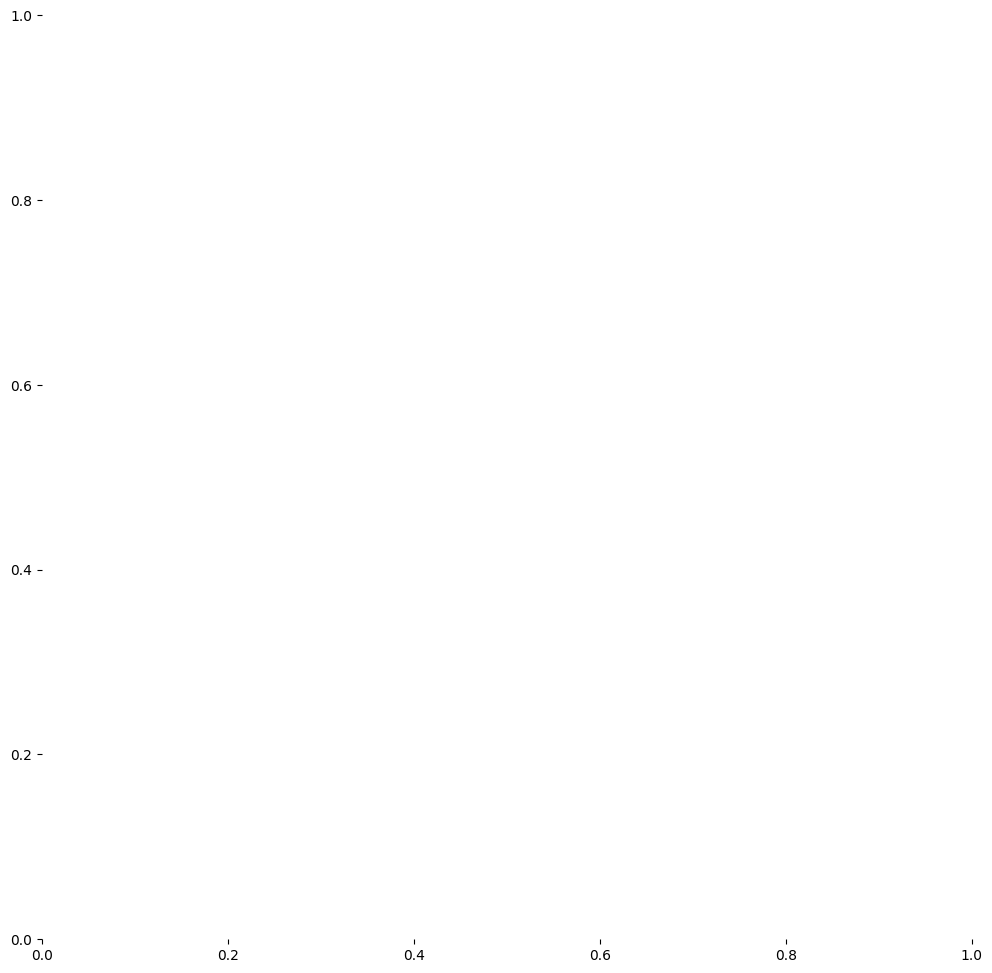

In [14]:
vis_model = vis.VisWNModel(inp_path)

In [15]:
junction_names = model.superjunctions['name'].iloc[:-2].values

In [16]:
max_limit = mads[0].mean(axis=0).quantile(0.9)

In [17]:
validation_node_list = ['29', '311', '336', '641']

## Figure 5: State estimation performance in PA1: spatial distribution of MAD with added sensors.

/var/folders/y2/lnpd45md64q2_p_6xfg9y5cr0000gn/T/ipykernel_3249/527965559.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


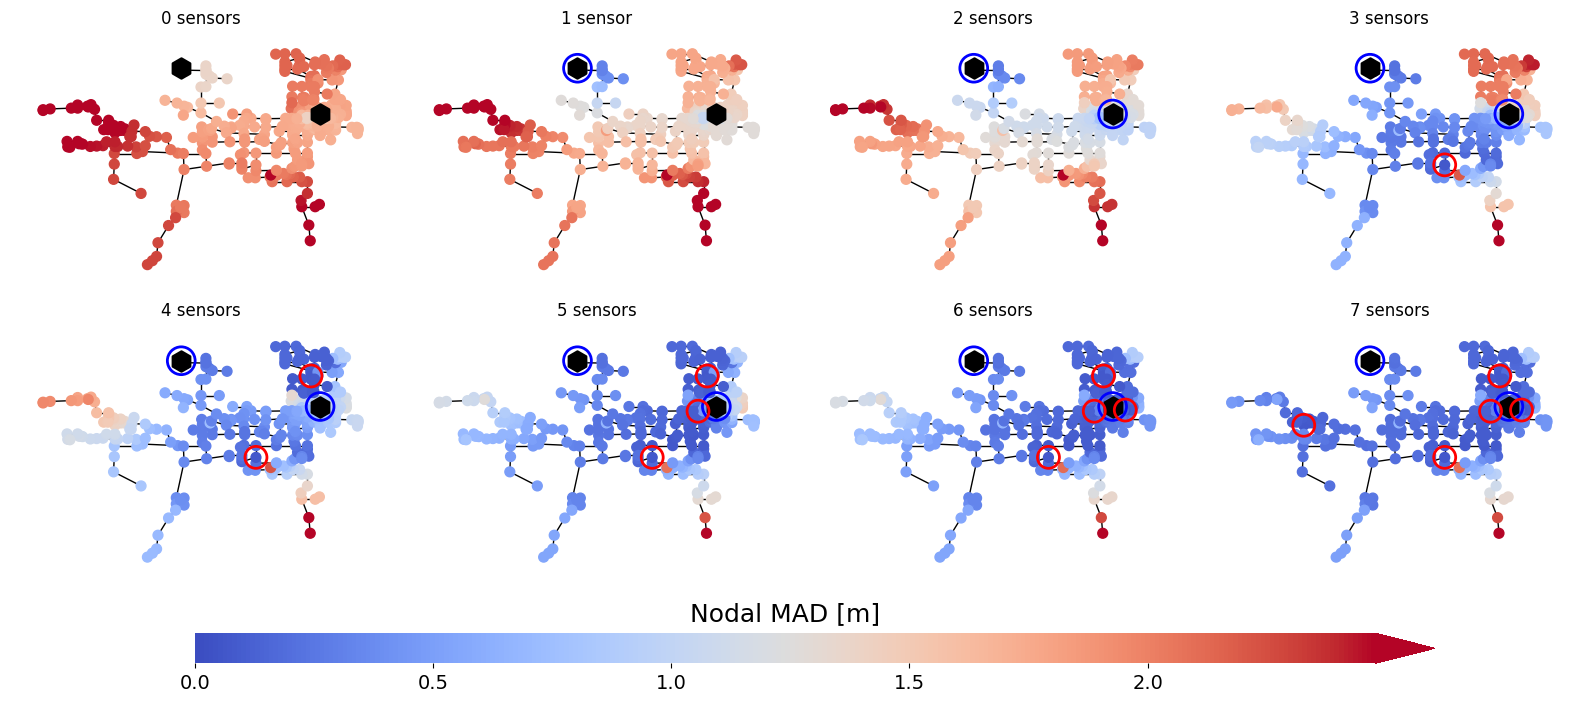

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(16, 6))
cmap = 'coolwarm'
node_size = 200

sensor_range = [0, 1, 2, 3, 4, 5, 6, 7]

for axnum, i in enumerate(sensor_range):
    if i == 1:
        plural = ''
    else:
        plural = 's'
    err = mads[i][junction_names].mean(axis=0)
    ax.flat[axnum].set_frame_on(False) 
    node_size = 200
    vis_model.plot_unique_data(ax=ax.flat[axnum], parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
                           node_size = node_size, legend=False, tank_color='k')
    for j in range(i):
        k = j + 1
        if k <= 2:
            c = 'b'
            node_size = 1600
#        elif k == 3:
#            c = 'g'
#            node_size = 1000
        else:
            c = 'r'
            node_size = 1000
        vis_model.draw_nodes(ax=ax.flat[axnum], node_list=[msmts[j]], node_color="none", node_size=node_size,
                                 edge_colors=c, line_widths=2)
    ax.flat[axnum].set_title(f'{i} sensor{plural}')
    
norm = mpl.colors.Normalize(vmin=0,vmax=max_limit)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
dims = [ax[1, 0].get_position().x0, 
        ax[1, 0].get_position().y0-0.225,
        ax[1, -1].get_position().x1 - ax[1, 0].get_position().x0,
        0.05]
cax = fig.add_axes(dims)
cb = fig.colorbar(sm, cax=cax, orientation = 'horizontal', extend='max')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='Nodal MAD [m]',fontsize = 18, labelpad=-65)
cb.outline.set_visible(False)

plt.tight_layout()
plt.savefig('img/PA1_sensor_progression.pdf', bbox_inches='tight')
plt.savefig('img/PA1_sensor_progression.png', dpi=200, bbox_inches='tight')

In [19]:
import seaborn as sns

In [20]:
buffer_distance = 1500

## Figure 4: State estimation performance in PA1: model-based estimation (blue), true heads at holdout locations (Nodes 29, 311, 366, and 641) (dotted black), and the EKF estimates with increasing number of sensors: 1 sensor (light red) – 7 sensors (dark red).

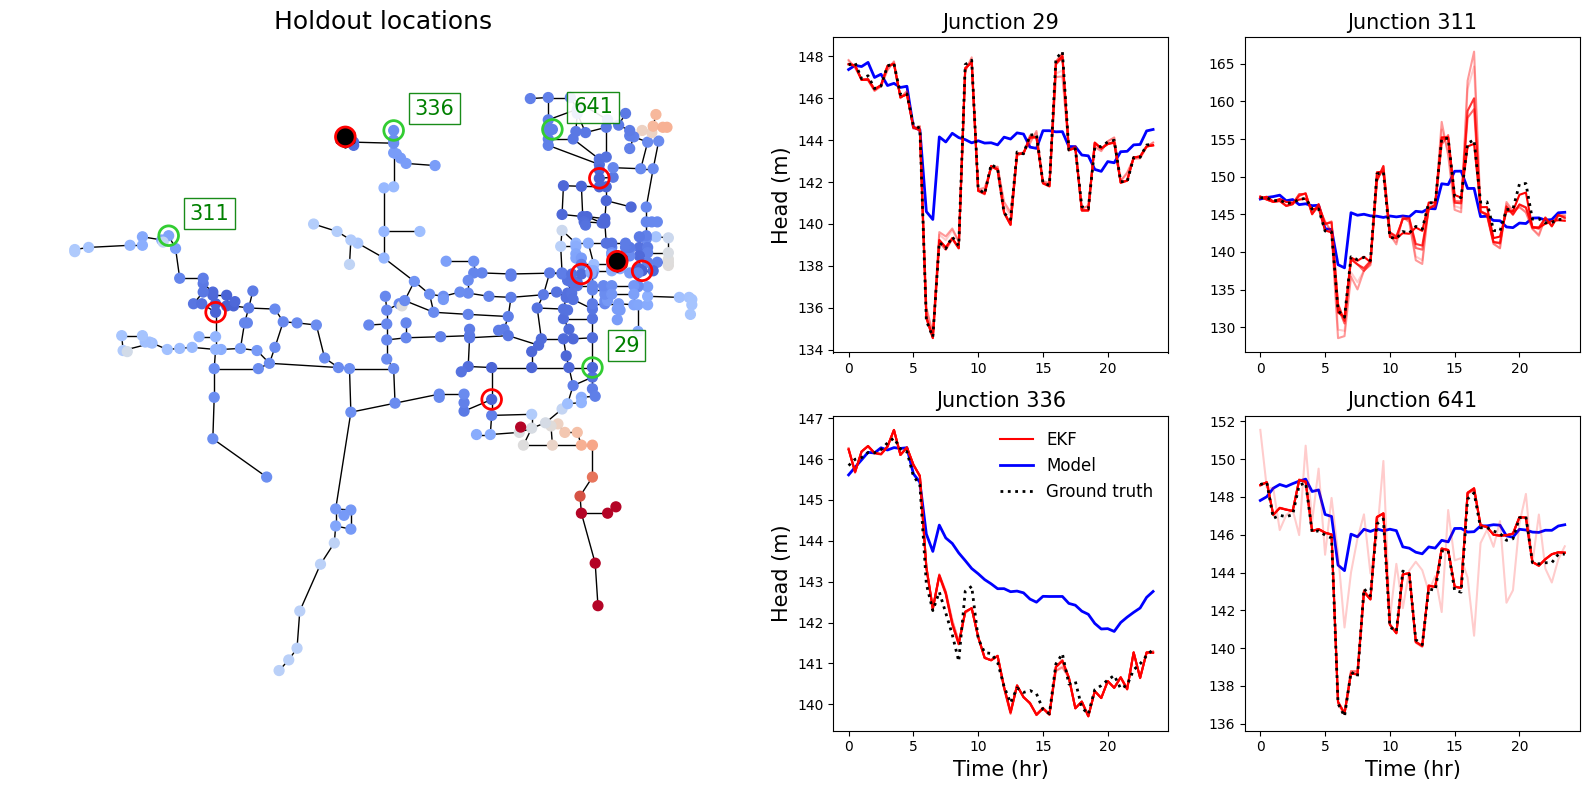

In [21]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

fs = 15
node_size = 200

max_limit = mads[7].mean(axis=0).quantile(0.99)


ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan = 2)
ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 2))
ax3 = plt.subplot2grid(shape=(2, 4), loc=(0, 3))
ax4 = plt.subplot2grid(shape=(2, 4), loc=(1, 2))
ax5 = plt.subplot2grid(shape=(2, 4), loc=(1, 3))

for index, name in enumerate(validation_node_list):
    if index == 0:
        ax = ax2
    if index == 1:
        ax = ax3
    if index == 2:
        ax = ax4
    if index == 3:
        ax = ax5
    for i in range(1, 5):

        ax.plot(kf[2+i][name].index / 3600, kf[2+i][name].values, c='r', alpha=0.2*i, label='_nolegend', zorder=i)
    ax.plot(kf[7][name].index / 3600, kf[7][name].values, c='r', label='EKF', zorder=i + 1)

    ax.plot(kf[0][name].index / 3600, kf[0][name].values, c='b', linewidth=2, label='Model', zorder=0)
    ax.plot(H_df_real[name].index / 3600, H_df_real[name].values, c='k', linewidth=2, linestyle=':', label='Ground truth', zorder=i + 2)
    ax.set_title(f'Junction {name}', size=fs)
    
ax4.legend(frameon = False, fontsize= 12)
ax2.set_ylabel('Head (m)', size=fs)
ax4.set_ylabel('Head (m)', size=fs)
ax4.set_xlabel('Time (hr)', size=fs)
ax5.set_xlabel('Time (hr)', size=fs)
     
    
ax1.set_frame_on(False) 
#node_size = 100
vis_model.plot_unique_data(ax=ax1, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
                           node_size = node_size, legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax1, node_list=msmts, node_color="none", node_size=800,
                                 edge_colors='r', line_widths=2)
vis_model.draw_nodes(ax=ax1, node_list=validation_node_list, node_color="none", node_size=800,
                                 edge_colors='limegreen', line_widths=2)
for j in range(len(validation_node_list)):
    ax1.text(wn.get_node(validation_node_list[j]).coordinates[0]+buffer_distance,
                      wn.get_node(validation_node_list[j]).coordinates[1]+buffer_distance, '{}'.format(validation_node_list[j]),
                      color='g' , fontsize = 15, 
                      bbox=dict(facecolor='white', alpha = 0.9, edgecolor='g'))

ax1.set_title('Holdout locations', fontsize=18)

plt.tight_layout()
plt.savefig('img/PA1_closeups.pdf', bbox_inches='tight')
plt.savefig('img/PA1_closeups.png', dpi=200, bbox_inches='tight')